# Model evaluation and drawing sheeeet

In [1]:
from models import *
from utils import set_seed
from data.loaders import * 

In [2]:
user = 'ajimenez'

In [3]:
path_to_model = f"/home/{user}/CoSE-pytorch/wandb/run-20210128_122647-3iw8z8ml/files/weights_trained/epoch_2"
path_to_model = f"/home/{user}/CoSE-pytorch/pesos_descargados"
path_to_model = "/home/shuaman/CoSE/CoSE-pytorch/wandb/latest-run/files/weights_trained/epoch_45"
#path_to_model = f"/home/{user}/CoSE-pytorch/wandb/run-20210129_053415-2912fvg5/files/weights_trained/epoch_10"

In [4]:
set_seed(0)
device = torch.device('cuda:2')
cose = CoSEModel('config_v2.json', False)
cose.encoder.load_state_dict(torch.load(os.path.join(os.getcwd(), path_to_model,"encoder.pth"), map_location=device))
cose.decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model ,"decoder.pth"), map_location=device))
cose.position_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"pos_pred.pth"), map_location=device))
cose.embedding_predictive_model.load_state_dict(torch.load(os.path.join(os.getcwd(),path_to_model,"emb_pred.pth"), map_location=device))

<All keys matched successfully>

In [5]:
val_path = f"/data/{user}/cose/train/"

In [6]:
batchdata = BatchCoSELoader(path = val_path,
                    filenames={"inputs_file" : "inputs_list_based_x16.pkl",
                               "targets_file": "target_list_based_x16.pkl"
                              }
                )

valid_loader = DataLoader(
                    dataset =batchdata,
                    batch_size = 1, #data is already in batch mode, batch_size = 1 means iterating every .get_next() returns a new batch
                )

In [7]:
from utils.visualization import * 

In [8]:
stats_json = 'didi_wo_text-stats-origin_abs_pos.json'
stats_path = '/data/jcabrera/didi_wo_text/'
with open(os.path.join(stats_path, stats_json)) as json_file:
    stats = json.load(json_file)

In [9]:
mean_channel = stats['mean_channel'][:2]
std_channel = np.sqrt(stats['var_channel'][:2])

In [10]:
log_dir = f'/home/ajimenez/pruebas'

In [11]:
for batch_input, batch_target in iter(valid_loader):
    break

In [12]:
i_diagram = 7

In [13]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
seq_len_drawing = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()

In [14]:
enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = seq_len_drawing.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

In [15]:
i_diagram = 5

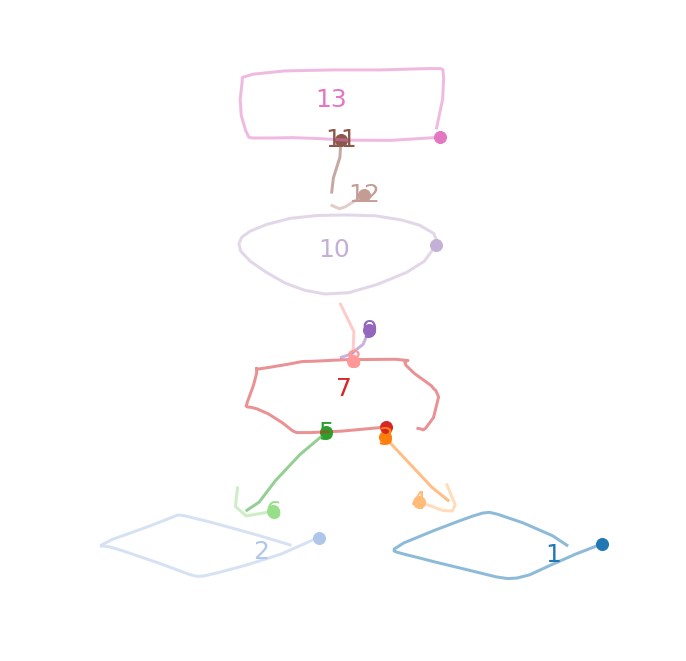

In [16]:
npfig, fig, _, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram], mean_channel,
                               std_channel, num_strokes=num_strokes[i_diagram], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

## Pasando data por el modelo

In [17]:
device = "cuda:2"

In [18]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0).to(device)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0).to(device)
strok_len_inputs = batch_input['seq_len'].squeeze(dim = 0).to(device)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze().to(device)
end_coord = batch_input['end_coord'].squeeze(dim = 0).squeeze().to(device)

In [19]:
_, look_ahead_mask, _ = generate_3d_mask(encoder_inputs, strok_len_inputs,'cuda:2')

In [20]:
encoder_out = cose.encoder(encoder_inputs.permute(1,0,2), strok_len_inputs, look_ahead_mask)

### Reviewing random sampling function

In [21]:
def get_random_inp_target_pairs(num_strokes_x_diagram_tensor, padded_max_num_strokes, num_diagrams, min_n_stroke, device):
    #TODO Revisar
    """Get a randomly generated input set and a target."""
    n_inputs = torch.randint(2, min_n_stroke,size = (1,)).to(device).item() #validated with tf
    target_indexes = (torch.rand([num_diagrams]).to(device)*(num_strokes_x_diagram_tensor - 1)).int() #validated with tf
    input_range = torch.arange(start=0, end = padded_max_num_strokes).repeat(num_diagrams,1).to(device) #validated with tf
    mask = ((input_range)< num_strokes_x_diagram_tensor.reshape(-1,1)) & ((input_range -1) != target_indexes.reshape(-1,1)) #validated with tf
    input_indexes = torch.multinomial((input_range*mask).float().to(device),n_inputs) #validated with tf
    return input_indexes, target_indexes, n_inputs

def get_ordered_inp_target_pairs(num_strokes_x_diagram_tensor, padded_max_num_strokes, num_diagrams, min_n_stroke, device, random_target = False):
    #TODO Revisar
    """Get a slice (i.e., window) randomly."""
    n_inputs = torch.randint(2, (min_n_stroke),size = (1,)).to(device).item()
    start_index = torch.randint(0, min_n_stroke - n_inputs, size = (1,)).to(device).item()
    target_indexes = torch.tensor([start_index+n_inputs+1]).repeat(num_diagrams,1).to(device)
    input_range = torch.arange(start=1, end = padded_max_num_strokes + 1).repeat(num_diagrams,1).to(device)
    mask = ((input_range)< target_indexes) & ((input_range)> start_index)
    input_indexes = input_range.masked_select(mask).reshape(num_diagrams, n_inputs)
    return input_indexes, target_indexes, n_inputs

### sample random inp target pair

In [23]:
def random_index_sampling(encoder_out,inputs_start_coord,inputs_end_coord,num_strokes_x_diagram_tensor,
                         input_type ="hybrid", num_predictive_inputs = 32, replace_padding = True, end_positions = False, device = None):
    #================================#
    diagram_embedding, padded_max_num_strokes, min_n_stroke, num_diagrams = reshape_stroke2diagram(encoder_out,num_strokes_x_diagram_tensor)
    start_pos_base = inputs_start_coord.reshape(num_diagrams,padded_max_num_strokes,2)
    #num_predictive_inputs = 32
    if input_type == "hybrid":
        num_predictive_inputs //= 2
    #creates indexes to gather from
    # -----------------------#
    all_input_emb = []
    all_input_start_pos = []
    all_seq_len_emb = []
    #-----------------------#
    all_target_emb = []
    all_target_start_pos = []
    all_n_inputs = []

    if input_type in ["random", "hybrid"]:
        for i in range(num_predictive_inputs):
            input_indexes, target_indexes, n_inputs = get_random_inp_target_pairs(num_strokes_x_diagram_tensor,
                                                                                  padded_max_num_strokes,
                                                                                  num_diagrams,
                                                                                  min_n_stroke, device)
            #-------------------------------------#
            input_embedding = torch.stack([diagram_embedding[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
            input_start_pos = torch.stack([start_pos_base[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
            target_embedding = torch.stack([diagram_embedding[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
            target_start_pos = torch.stack([start_pos_base[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
            seq_len_embedding = torch.ones([num_diagrams])*n_inputs
            #---------------------------------------#
            all_input_emb.append(input_embedding)
            all_input_start_pos.append(input_start_pos)
            all_target_emb.append(target_embedding)
            all_target_start_pos.append(target_start_pos)
            all_seq_len_emb.append(seq_len_embedding)
            all_n_inputs.append(n_inputs)
    if input_type in ["order", "hybrid"]:
        for i in range(num_predictive_inputs):
            input_indexes, target_indexes, n_inputs = get_ordered_inp_target_pairs(num_strokes_x_diagram_tensor,
                                                                                   padded_max_num_strokes,
                                                                                   num_diagrams,
                                                                                   min_n_stroke, device)
            #----------------------------------------------------#
            input_embedding = torch.stack([diagram_embedding[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
            input_start_pos = torch.stack([start_pos_base[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
            target_embedding = torch.stack([diagram_embedding[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
            target_start_pos = torch.stack([start_pos_base[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
            seq_len_embedding = torch.ones([num_diagrams])*n_inputs
            #-----------------------------------------------------#
            all_input_emb.append(input_embedding)
            all_input_start_pos.append(input_start_pos)
            all_target_emb.append(target_embedding)
            all_target_start_pos.append(target_start_pos)
            all_seq_len_emb.append(seq_len_embedding)
            all_n_inputs.append(n_inputs)
            #------------------------------------------------------#
    sampled_seq_len_emb = torch.stack(all_seq_len_emb)
    sampled_target_start_pos = torch.stack(all_target_start_pos)
    sampled_target_emb = torch.stack(all_target_emb)
    sampled_input_start_pos = torch.zeros(32, num_diagrams, max(all_n_inputs),2)
    #-------------------------------------------------------------#
    for i_sample, sampled_data in enumerate(all_input_start_pos):
        for i_diagram, content in enumerate(sampled_data):
            sampled_input_start_pos[i_sample,i_diagram,:int(all_seq_len_emb[i_sample][i_diagram]),:] = content

    sampled_input_emb = torch.zeros(32, num_diagrams, max(all_n_inputs),8)
    for i_sample, sampled_data in enumerate(all_input_emb):
        for i_diagram, content in enumerate(sampled_data):
            sampled_input_emb[i_sample,i_diagram,:int(all_seq_len_emb[i_sample][i_diagram]),:] = content
    #-------------------------------------------------------------#
    sampled_input_start_pos = sampled_input_start_pos.reshape(-1, sampled_input_start_pos.size(-2), sampled_input_start_pos.size(-1))
    sampled_input_emb = sampled_input_emb.reshape(-1, sampled_input_emb.size(-2), sampled_input_emb.size(-1))
    sampled_seq_len_emb = sampled_seq_len_emb.reshape(-1)
    sampled_target_start_pos = sampled_target_start_pos.reshape(-1, sampled_target_start_pos.size(-1))
    sampled_target_emb = sampled_target_emb.reshape(-1, sampled_target_emb.size(-1))
    return sampled_input_start_pos, sampled_input_emb, sampled_seq_len_emb, sampled_target_start_pos, sampled_target_emb

In [24]:
sampled_input_start_pos, sampled_input_emb,sampled_seq_len_emb,sampled_target_start_pos,sampled_target_emb = random_index_sampling(encoder_out = encoder_out, inputs_start_coord = start_coord,
                                                                                                                                   inputs_end_coord = end_coord, num_strokes_x_diagram_tensor = num_strokes,
                                                                                                                                   input_type ="hybrid", num_predictive_inputs = 32,
                                                                                                                                   replace_padding = True, end_positions = False, device = device)

In [27]:
sampled_input_start_pos.shape

torch.Size([192, 12, 2])

In [26]:
sampled_target_start_pos.shape

torch.Size([192, 2])

In [80]:
num_predictive_inputs = 32
if input_type == "hybrid":
    num_predictive_inputs //= 2

In [81]:
#creates indexes to gather from
# -----------------------#
all_input_emb = []
all_input_start_pos = []
all_seq_len_emb = []
#-----------------------#
all_target_emb = []
all_target_start_pos = []
all_n_inputs = []

if input_type in ["random", "hybrid"]:
    for i in range(num_predictive_inputs):
        input_indexes, target_indexes, n_inputs = get_random_inp_target_pairs(num_strokes_x_diagram_tensor,
                                                                              padded_max_num_strokes,
                                                                              num_diagrams,
                                                                              min_n_stroke, device)
        ####
        input_embedding = torch.stack([diagram_embedding[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
        input_start_pos = torch.stack([start_pos_base[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
        target_embedding = torch.stack([diagram_embedding[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
        target_start_pos = torch.stack([start_pos_base[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
        seq_len_embedding = torch.ones([num_diagrams])*n_inputs
        #
        all_input_emb.append(input_embedding)
        all_input_start_pos.append(input_start_pos)
        all_target_emb.append(target_embedding)
        all_target_start_pos.append(target_start_pos)
        all_seq_len_emb.append(seq_len_embedding)
        all_n_inputs.append(n_inputs)

In [82]:
if input_type in ["order", "hybrid"]:
    for i in range(num_predictive_inputs):
        input_indexes, target_indexes, n_inputs = get_ordered_inp_target_pairs(num_strokes_x_diagram_tensor,
                                                                               padded_max_num_strokes,
                                                                               num_diagrams,
                                                                               min_n_stroke, device)
        ####
        input_embedding = torch.stack([diagram_embedding[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
        input_start_pos = torch.stack([start_pos_base[diagram_index][input_indexes[diagram_index]] for diagram_index in range(num_diagrams)])
        target_embedding = torch.stack([diagram_embedding[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
        target_start_pos = torch.stack([start_pos_base[diagram_index][target_indexes[diagram_index]] for diagram_index in range(num_diagrams)]).squeeze()
        seq_len_embedding = torch.ones([num_diagrams])*n_inputs
        #
        all_input_emb.append(input_embedding)
        all_input_start_pos.append(input_start_pos)
        all_target_emb.append(target_embedding)
        all_target_start_pos.append(target_start_pos)
        all_seq_len_emb.append(seq_len_embedding)
        all_n_inputs.append(n_inputs)

In [83]:
sampled_seq_len_emb = torch.stack(all_seq_len_emb)
sampled_target_start_pos = torch.stack(all_target_start_pos)
sampled_target_emb = torch.stack(all_target_emb)

In [84]:
sampled_seq_len_emb.shape
sampled_target_start_pos.shape

torch.Size([32, 6, 2])

In [85]:
sampled_input_start_pos = torch.zeros(32, num_diagrams, max(all_n_inputs),2)
for i_sample, sampled_data in enumerate(all_input_start_pos):
    for i_diagram, content in enumerate(sampled_data):
        sampled_input_start_pos[i_sample,i_diagram,:int(all_seq_len_emb[i_sample][i_diagram]),:] = content
        
sampled_input_emb = torch.zeros(32, num_diagrams, max(all_n_inputs),8)
for i_sample, sampled_data in enumerate(all_input_emb):
    for i_diagram, content in enumerate(sampled_data):
        sampled_input_emb[i_sample,i_diagram,:int(all_seq_len_emb[i_sample][i_diagram]),:] = content

In [86]:
sampled_input_start_pos = sampled_input_start_pos.reshape(-1, sampled_input_start_pos.size(-2), sampled_input_start_pos.size(-1))
sampled_input_emb = sampled_input_emb.reshape(-1, sampled_input_emb.size(-2), sampled_input_emb.size(-1))
sampled_seq_len_emb = sampled_seq_len_emb.reshape(-1)
sampled_target_start_pos = sampled_target_start_pos.reshape(-1, sampled_target_start_pos.size(-1))
sampled_target_emb = sampled_target_emb.reshape(-1, sampled_target_emb.size(-1))

In [87]:
sampled_input_start_pos.shape, sampled_input_emb.shape,sampled_seq_len_emb.shape,sampled_target_start_pos.shape,sampled_target_emb.shape

(torch.Size([192, 12, 2]),
 torch.Size([192, 12, 8]),
 torch.Size([192]),
 torch.Size([192, 2]),
 torch.Size([192, 8]))

In [49]:
expected_strokes = encoder_inputs
expected_start_coord = start_coord
pred_embedding = encoder_out
recon_start_coord = start_coord
strok_len_inputs = strok_len_inputs
#decoder= cose.decoder
skip_rows = 0

In [50]:
loss_ae = 0
mean_chamfer_dist = 0
q = 0
chamferDist = ChamferDistance()
total_chamfer_dist = []
recons_strokes = []
recon_start_pos = []
strok_len_inp = []
for i, stroke_embedding in enumerate(pred_embedding):
    if strok_len_inputs[i] > 0 and strok_len_inputs[i] < 100:
        t_inputs = torch.linspace(0, 1, steps=strok_len_inputs[i]).to(device)
        t_inp = t_inputs.reshape(1,-1)
        stroke_emb = stroke_embedding.reshape(1,-1).repeat(t_inp.size(-1), 1)
        t_inp = t_inp.reshape(-1,1)
        recons_input = torch.cat([stroke_emb, t_inp], dim = 1)
        recons_stroke, ae_mu, ae_sigma, ae_pi= cose.decoder(recons_input)
        orig_stroke_ = expected_strokes[i:i+1,:strok_len_inputs[i],:2]
        orig_pos = expected_start_coord[i:i+1,:]
        recon_stroke_ = recons_stroke.reshape(-1, strok_len_inputs[i],2)
        recon_pos = recon_start_coord[i:i+1,:]
        #orig_stroke_ = torch.from_numpy(orig_stroke_.cpu().detach().numpy()*std_channel + mean_channel).to(device) + orig_pos
        #recon_stroke_ = torch.from_numpy(recon_stroke_.cpu().detach().numpy()*std_channel + mean_channel).to(device) + recon_pos
        recons_strokes.append(recon_stroke_.squeeze(dim = 0))
        recon_start_pos.append(recon_pos.squeeze(dim = 0))
        strok_len_inp.append(strok_len_inputs[i].squeeze(dim = 0))
        if i >= skip_rows:
            loss_ae += -1*(logli_gmm_logsumexp(orig_stroke_.detach(), ae_mu.detach(), ae_sigma.detach(), ae_pi.detach()).mean().item())
            #print(loss_ae)
            orig_stroke_ = torch.from_numpy(orig_stroke_.cpu().detach().numpy()*std_channel + mean_channel).to(device) + orig_pos
            recon_stroke_ = torch.from_numpy(recon_stroke_.cpu().detach().numpy()*std_channel + mean_channel).to(device) + recon_pos
            
            total_chamfer_dist.append(chamferDist(orig_stroke_, recon_stroke_).item())
            #if total_chamfer_dist
            #print(total_chamfer_dist)
            q+=1
        #break
    #else:
    #    print(f"skipping {i} iteration")
loss_ae = loss_ae/q
mean_chamfer_dist = np.mean(total_chamfer_dist)

In [51]:
loss_ae

661.8365539757602

In [52]:
mean_chamfer_dist

0.10411548148511901

In [53]:
%matplotlib inline


In [54]:
i = 80

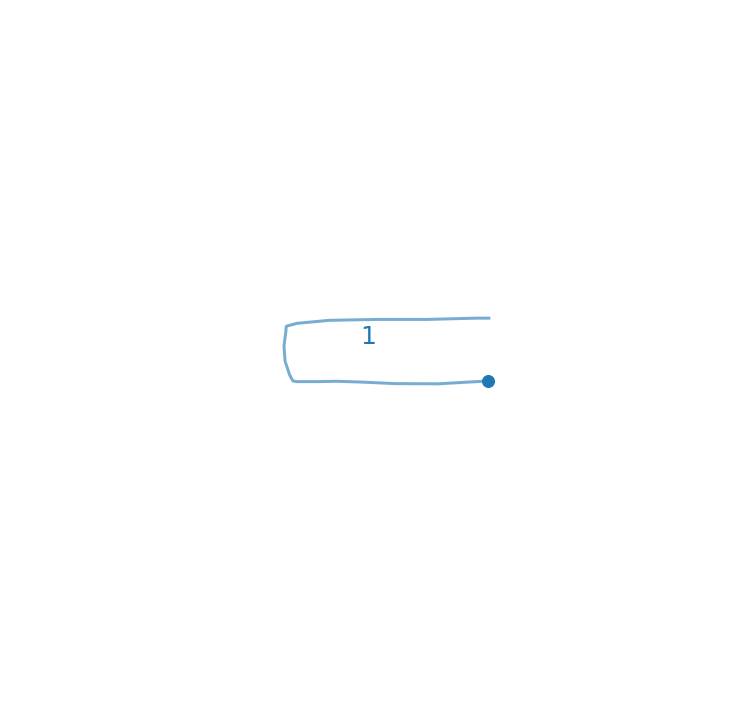

In [55]:
npfig, _, _, _  = transform_strokes_to_image(drawing=orig_stroke_.cpu().detach(), seq_len_drawing=[strok_len_inputs[i].cpu().detach()], start_coord_drawing=orig_pos.cpu().detach(), mean_channel=mean_channel,
                                                     std_channel=std_channel, num_strokes=None,output_path="./", output_file="pinha", square_figure=True, save=True, alpha=0.6, highlight_start=True)

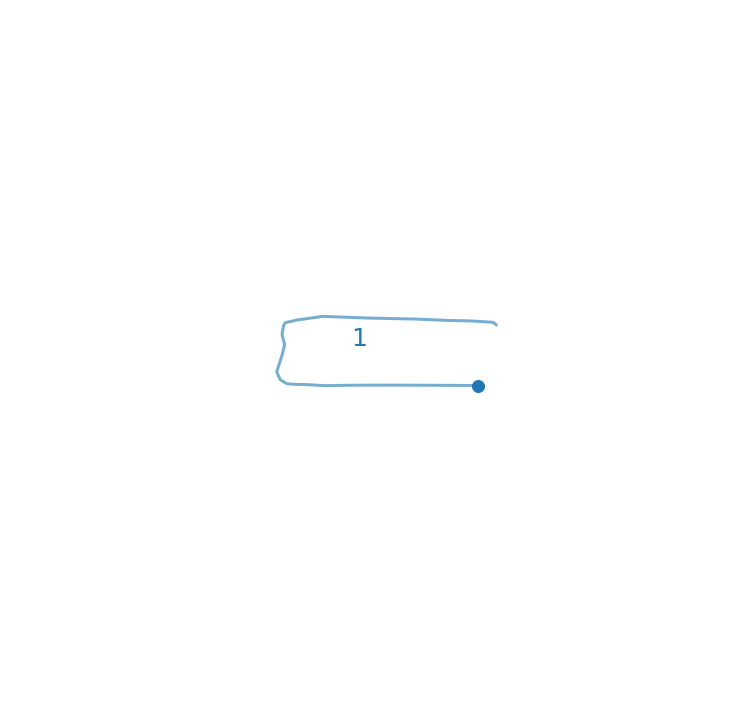

In [56]:
npfig2, _, _, _ = transform_strokes_to_image(drawing=recon_stroke_.cpu().detach(), seq_len_drawing=[strok_len_inputs[i].cpu().detach()], start_coord_drawing=recon_pos.cpu().detach(), mean_channel=mean_channel,
                                                     std_channel=std_channel, num_strokes=None, output_path="./", output_file="pinha", square_figure=True, save=True, alpha=0.6, highlight_start=True)

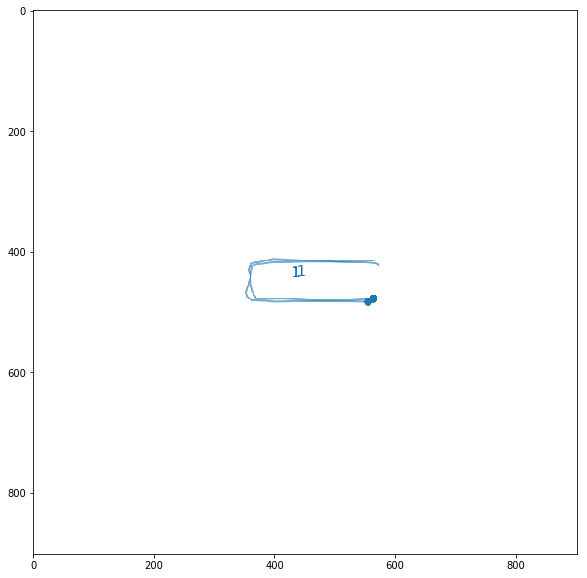

In [57]:
plt.figure(figsize = (10,10))
plt.imshow(npfig)
plt.imshow(npfig2)

In [30]:
from chamferdist import ChamferDistance
def get_reconstruction_metrics(expected_strokes, expected_start_coord, pred_embedding, recon_start_coord, strok_len_inputs, decoder, mean_channel, std_channel,device, skip_rows = 0):
    loss_ae = 0
    mean_chamfer_dist = 0
    q = 0
    chamferDist = ChamferDistance()
    total_chamfer_dist = 0
    recons_strokes = []
    for i, stroke_embedding in enumerate(pred_embedding):
        if strok_len_inputs[i] > 0:
            t_inputs = torch.linspace(0, 1, steps=strok_len_inputs[i]).to(device)
            t_inp = t_inputs.reshape(1,-1)
            stroke_emb = stroke_embedding.reshape(1,-1).repeat(t_inp.size(-1), 1)
            t_inp = t_inp.reshape(-1,1)
            recons_input = torch.cat([stroke_emb, t_inp], dim = 1)
            recons_stroke, ae_mu, ae_sigma, ae_pi= decoder(recons_input)
            orig_stroke_ = expected_strokes[i:i+1,:strok_len_inputs[i],:2]
            orig_pos = expected_start_coord[i:i+1,:]
            recon_stroke_ = recons_stroke.reshape(-1, strok_len_inputs[i],2)
            recon_pos = recon_start_coord[i:i+1,:]
            if i >= skip_rows:
                recons_strokes.append(recon_stroke_.squeeze(dim = 0))
                loss_ae += -1*(logli_gmm_logsumexp(orig_stroke_, ae_mu, ae_sigma, ae_pi).mean())
                orig_stroke_ = torch.from_numpy(orig_stroke_.cpu().detach().numpy()*std_channel + mean_channel).to(device) + orig_pos
                recon_stroke_ = torch.from_numpy(recon_stroke_.cpu().detach().numpy()*std_channel + mean_channel).to(device) + recon_pos
                total_chamfer_dist += chamferDist(orig_stroke_, recon_stroke_)
                q+=1
            else:
                recons_strokes.append(orig_stroke_.squeeze(dim = 0))
    loss_ae = loss_ae/q
    mean_chamfer_dist = total_chamfer_dist/q
    return loss_ae, mean_chamfer_dist, recons_strokes

In [31]:
loss_ae, chamf_dist,_ = get_reconstruction_metrics(encoder_inputs, start_coord ,encoder_out,start_coord, strok_len_inputs, cose.decoder, mean_channel, std_channel, device)

In [32]:
loss_ae.item()

661.8365478515625

In [33]:
chamf_dist.item()

0.10411548148511904

In [34]:
chamf_dist

tensor(0.1041, device='cuda:2', dtype=torch.float64)

In [35]:
chamf_dist

tensor(0.1041, device='cuda:2', dtype=torch.float64)

In [36]:
diagram_embedding, padded_max_num_strokes, _, num_diagrams = reshape_stroke2diagram(encoder_out,num_strokes)
start_pos_base = start_coord.reshape(num_diagrams,padded_max_num_strokes,2)

In [37]:
use_autoregressive = False

In [55]:
def get_prediction_metrics(encoder_inputs, strok_len_inputs, diagram_embedding, start_pos_base, num_strokes, models, device, mean_channel, std_channel, use_autoregressive = False):
    decoder, position_predictive_model, embedding_predictive_model = models
    # Num_strokes_iniciales
    n_strokes_init = 2
    #for every diagram
    loss_pos_pred =  []
    loss_emb_pred = []
    pred_cd = []
    reconstructed_diagrams_strokes = []
    reconstructed_diagrams_start_pos = []
    for index_diagram in range(diagram_embedding.size(0)):
        #diagram inputs
        num_strokes_one = num_strokes[index_diagram]
        one_diagram = diagram_embedding[index_diagram].unsqueeze(dim =0)
        start_pos_one = start_pos_base[index_diagram].unsqueeze(dim = 0)
        expected_output_one = encoder_inputs.reshape(num_diagrams,-1,encoder_inputs.size(1), encoder_inputs.size(2))[index_diagram,:num_strokes_one,:,:]
        stroke_len_one = strok_len_inputs.reshape(num_diagrams,-1)[index_diagram,:]
        #starting config
        inp_diagram_cum = one_diagram[:,:n_strokes_init,:]
        inp_start_pos_cum = start_pos_one[:,:n_strokes_init,:]
        #iterating to predict next stroke every time
        for j in range(n_strokes_init, num_strokes[index_diagram]):
            #inputs
            if not use_autoregressive:
                inp_diagram = one_diagram[:,:j,:]
                inp_start_pos = start_pos_one[:,:j,:]
            else:
                inp_diagram = inp_diagram_cum[:,:j,:]
                inp_start_pos = inp_start_pos_cum[:,:j,:]
            #targets
            target_diagram = one_diagram[:,j,:]
            target_start_pos = start_pos_one[:,j,:]
            #predictions
            inp_pos_model = torch.cat([inp_diagram, inp_start_pos], dim = 2)
            inp_num_strokes = torch.tensor([inp_diagram.size(1)])
            #pos prediction
            pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(inp_pos_model, inp_num_strokes, None)
            pos_pred = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi)  
            #next embedding prediction
#             print(inp_diagram.shape)
#             print(inp_start_pos.shape)
#             print(pos_pred.shape)
#             print(target_start_pos.shape)
            #break
            pred_model_inputs = torch.cat([inp_diagram, inp_start_pos, target_start_pos.unsqueeze(dim = 1).repeat(1, inp_num_strokes, 1)], dim = 2)
            #pred_model_inputs = torch.cat([inp_diagram, inp_start_pos, pos_pred.unsqueeze(dim = 1).repeat(1, inp_num_strokes, 1)], dim = 2)
            emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pred_model_inputs, inp_num_strokes, None)
            emb_pred = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi)
            #losses
            #loss_pos_pred += -1*(logli_gmm_logsumexp(inp_start_pos, pos_pred_mu, pos_pred_sigma, pos_pred_pi).mean())
            #loss_emb_pred += -1*(logli_gmm_logsumexp(target_diagram, emb_pred_mu, emb_pred_sigma, emb_pred_pi).mean())
            #print(-1*(logli_gmm_logsumexp(inp_start_pos, pos_pred_mu, pos_pred_sigma, pos_pred_pi).mean()))
            loss_pos_pred.append(-1*(logli_gmm_logsumexp(target_start_pos, pos_pred_mu, pos_pred_sigma, pos_pred_pi).mean()).item())
            loss_emb_pred.append(-1*(logli_gmm_logsumexp(target_diagram, emb_pred_mu, emb_pred_sigma, emb_pred_pi).mean()).item())
            #updating diagrams for autoregressiveness
            inp_diagram_cum = torch.cat([inp_diagram_cum, emb_pred.unsqueeze(dim = 1)], dim = 1)
            inp_start_pos_cum = torch.cat([inp_start_pos_cum, pos_pred.unsqueeze(dim = 1)], dim = 1)
        #print(stroke_len_one)
        _, chamf_dist, recon_strokes = get_reconstruction_metrics(expected_strokes= expected_output_one,
                                                                  expected_start_coord=start_pos_one.squeeze(dim=0)[:num_strokes[index_diagram]],
                                                                  pred_embedding=inp_diagram_cum.squeeze(dim = 0),
                                                                  recon_start_coord= inp_start_pos_cum.squeeze(dim=0),
                                                                  strok_len_inputs=stroke_len_one,
                                                                  decoder= decoder,
                                                                  mean_channel = mean_channel,
                                                                  std_channel = std_channel,
                                                                  device = device,
                                                                  skip_rows = n_strokes_init)
        #print(expected_output_one[0][:5,:])
        #print(recon_strokes[0][:5,:])
        pred_cd.append(chamf_dist.item())
        reconstructed_diagrams_strokes.append(recon_strokes)
        reconstructed_diagrams_start_pos.append(inp_start_pos_cum)
        
    total_emb_loss = np.array(loss_emb_pred).mean()
    total_pos_loss = np.array(loss_pos_pred).mean()
    total_pred_cd  = np.array(pred_cd).mean()
    
    return total_emb_loss, total_pos_loss, total_pred_cd, reconstructed_diagrams_strokes, reconstructed_diagrams_start_pos

In [56]:
emb_loss, pos_loss, pred_cd, recons_strokes, recons_start_pos = get_prediction_metrics(encoder_inputs =encoder_inputs,
                                                                                       strok_len_inputs = strok_len_inputs,
                                                                                       diagram_embedding = diagram_embedding,
                                                                                       start_pos_base = start_pos_base,
                                                                                       num_strokes = num_strokes,
                                                                                       models = [cose.decoder, cose.position_predictive_model, cose.embedding_predictive_model],
                                                                                       device = device,
                                                                                       mean_channel = mean_channel,
                                                                                       std_channel = std_channel,
                                                                                       use_autoregressive = False)

In [57]:
emb_loss,pos_loss,pred_cd

(-2.2609002911288973, 1.042940101153414, 7.339243867235354)

In [58]:
i_diagram = 2

In [59]:
recons_strokes_padded_i = torch.nn.utils.rnn.pad_sequence(recons_strokes[i_diagram], batch_first=True, padding_value=0.0).cpu().detach()
seq_len_i = torch.tensor([len(i) for i in recons_strokes[i_diagram]]).cpu().detach()
recons_start_pos_i = recons_start_pos[i_diagram].squeeze().cpu().detach()
num_strokes_i = torch.tensor(len(recons_strokes[i_diagram])).cpu().detach()

In [60]:
encoder_inputs = batch_input['encoder_inputs'].squeeze(dim = 0)
num_strokes = batch_input['num_strokes'].squeeze(dim = 0)
seq_len_drawing = batch_input['seq_len'].squeeze(dim = 0)
start_coord = batch_input['start_coord'].squeeze(dim = 0).squeeze()

In [61]:
enc_inputs = encoder_inputs.reshape(-1, num_strokes.max(), encoder_inputs.size(1), encoder_inputs.size(2))
seq_len = seq_len_drawing.reshape(-1, num_strokes.max())
st_coord = start_coord.reshape(-1,num_strokes.max(), start_coord.size(1))

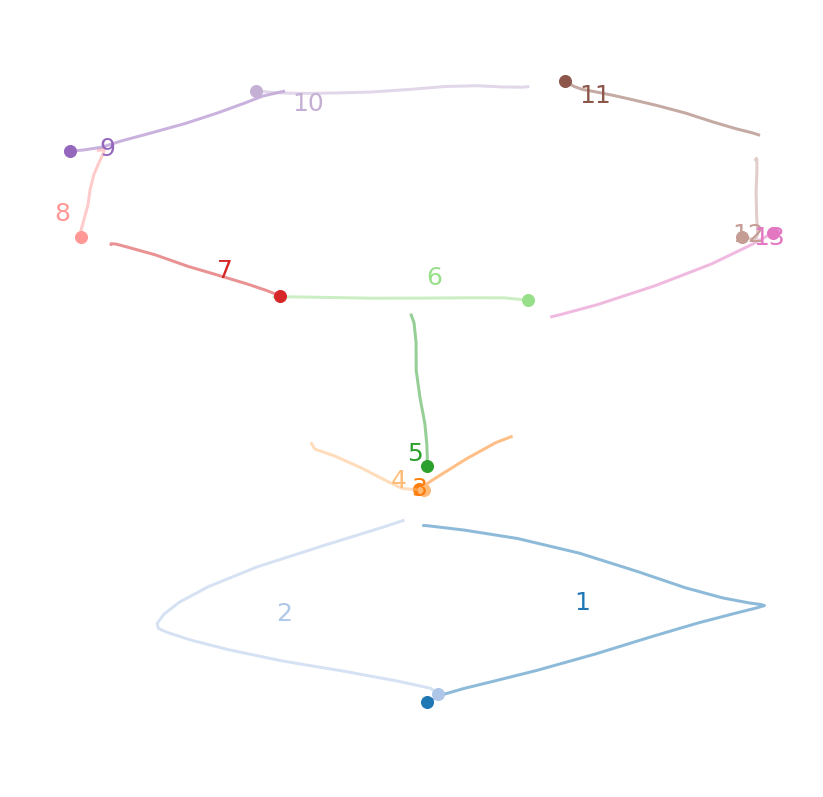

In [62]:
npfig, fig, _, _ = transform_strokes_to_image(enc_inputs[i_diagram], seq_len[i_diagram], st_coord[i_diagram], mean_channel,
                               std_channel, num_strokes=num_strokes[i_diagram], stroke_pred=None, start_coord_pred=None, output_path = log_dir, output_file = 'noutput_pruebas',  save  = True, square_figure=True, alpha=0.5, highlight_start=True)

(array([[[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],
 
        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],
 
        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],
 
        ...,
 
        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0]],
 
        [[255, 255, 255,   0],
         [255, 255, 255,   0],
         [255, 255, 255,   0],
         ...,
         [255, 255, 255,   0],
         [255, 255, 255,   0],
    

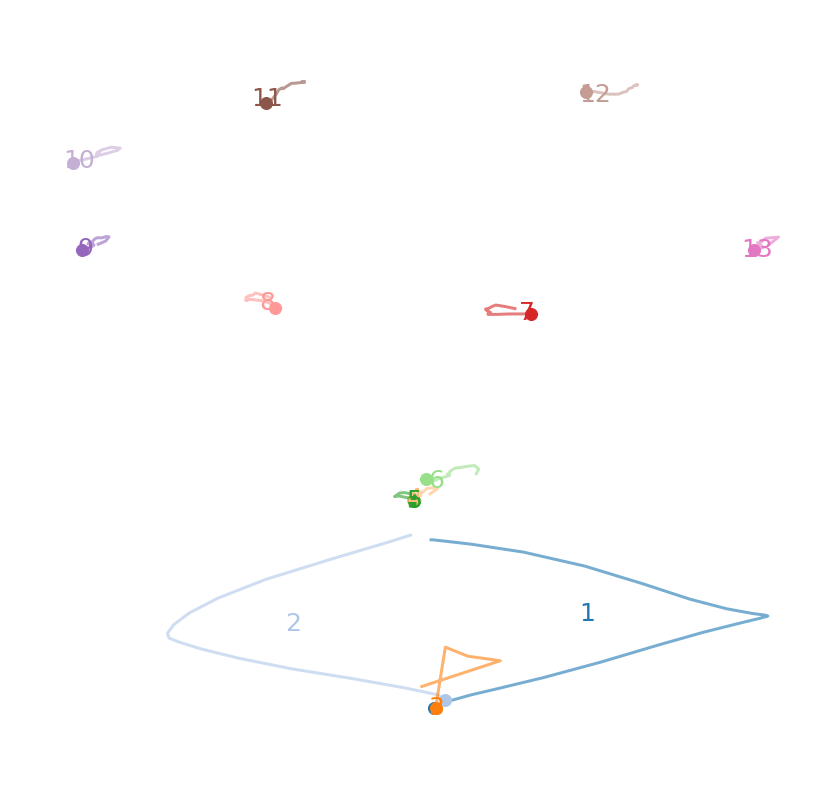

In [64]:
transform_strokes_to_image(drawing=recons_strokes_padded_i, seq_len_drawing=seq_len_i, start_coord_drawing=recons_start_pos_i, mean_channel=mean_channel,
                                                     std_channel=std_channel, num_strokes=num_strokes_i, output_path="./", output_file="pinha", square_figure=True, save=True, alpha=0.6, highlight_start=True)

In [76]:
recons_strokes_padded_i.shape,  seq_len_i.shape, recons_start_pos_i.shape,num_strokes.shape

(torch.Size([6, 99, 2]),
 torch.Size([6]),
 torch.Size([8, 2]),
 torch.Size([6, 99, 2]),
 torch.Size([]))

In [77]:
torch.randn(8,12,164,3)[0].shape, torch.randn(8,12)[0].shape, torch.randn(8,12,2)[0].shape, torch.randn(8)[0].shape 

(torch.Size([12, 164, 3]),
 torch.Size([12]),
 torch.Size([12, 2]),
 torch.Size([]))

In [67]:
recons_start_pos[0].squeeze().shape

torch.Size([8, 2])

In [54]:
num_strokes = None

In [ ]:
npfig, fig, _, file_save_path = tranform2image(recons_strokes[i_diagram], seq_len[i_diagram], recons_start_pos[i_diagram], mean_channel, std_channel, num_strokes[i_diagram], file_save_name="diagrama_n_{}".format(i_diagram))

In [48]:
torch.tensor(ls)[0]

tensor(6)

In [33]:
recons_strokes_padded.shape

torch.Size([6, 99, 2])

In [38]:
recons_strokes[5]

AttributeError: 'list' object has no attribute 'shape'

In [33]:
recons_start_pos[1]

NameError: name 'recons_start_pos' is not defined

In [44]:
pos_model_inputs = torch.cat([diagram_embedding, start_pos_base], dim = 2)

In [45]:
pos_pred_mu, pos_pred_sigma, pos_pred_pi = cose.position_predictive_model(pos_model_inputs, num_strokes, None)

In [46]:
pos_model_output = cose.position_predictive_model.draw_sample(pos_pred_mu, pos_pred_sigma, pos_pred_pi)

In [47]:
pred_model_inputs = torch.cat([diagram_embedding, start_pos_base, pos_model_output.unsqueeze(dim = 1).repeat(1, diagram_embedding.size(1), 1)], dim = 2)

In [48]:
emb_pred_mu, emb_pred_sigma, emb_pred_pi = cose.embedding_predictive_model(pred_model_inputs, num_strokes, None)

In [49]:
strokes_output = cose.embedding_predictive_model.draw_sample(emb_pred_mu, emb_pred_sigma, emb_pred_pi)

In [50]:
strokes_output.shape

torch.Size([8, 8])

In [59]:
points_q = 6

In [60]:
t_inputs = torch.linspace(0, 1, steps=points_q)
t_inputs=t_inputs.unsqueeze(dim=0).repeat(strokes_output.shape[0],1)
t_inputs=t_inputs.reshape((-1, 1))
strokes_output_r=strokes_output.repeat(points_q,1)
strokes_output_r.shape
t_inputs= t_inputs.to(device)
strokes_out = torch.cat([strokes_output_r, t_inputs], dim=1)


#flatten t_inputs (48, 1)
#repeat or tile strokes_output (batch_sizexpoints_q, 8) -> (48,8)
#concat t_inputs + strokes_output_reshapeo #(batch_sizexpoints_q, 9)
# entra al decoder
#draw sample del decoder

In [61]:
strokes_out, ae_mu, ae_sigma, ae_pi= cose.decoder(strokes_out)

In [63]:
drawing_out = strokes_out.reshape(-1,points_q,2)

In [71]:
drawing_out[i_diagram].unsqueeze(dim = 0).shape

torch.Size([1, 6, 2])

In [34]:
seq_len_out = (torch.ones((drawing_out.shape[0]))*points_q).int()

In [75]:
[seq_len_out[i_diagram]]

[tensor(6, dtype=torch.int32)]

In [35]:
drawing_out_cpu = drawing_out.cpu().detach()#.numpy()
pos_model_output_cpu = pos_model_output.cpu().detach()#.numpy()

In [78]:
#check_again

In [101]:
encoder_inputs.reshape(-1, padded_max_num_strokes, encoder_inputs.size(1), encoder_inputs.size(2))[i_diagram].shape

torch.Size([12, 164, 3])

In [102]:
drawing_i.shape

torch.Size([1, 6, 2])

In [91]:
drawing_i = drawing_out_cpu[i_diagram].unsqueeze(dim = 0)
start_coor_i = [pos_model_output_cpu[i_diagram]]
len_i  = [seq_len_out[i_diagram]]

In [106]:
drawing_i

tensor([[[-0.2522, -0.2008],
         [ 0.1434,  0.1132],
         [ 0.2259,  0.3366],
         [ 0.3154,  0.6044],
         [ 0.1262,  0.2051],
         [ 0.2116,  0.8331]]])

In [107]:
start_coor_i

[tensor([1.2675, 0.4312])]

In [108]:
len_i

[tensor(6, dtype=torch.int32)]

In [92]:
# if drawing_out_cpu.shape[2] == 2:
#     drawing_out_cpu = np.concatenate([drawing_out_cpu, torch.zeros(drawing_out_cpu.size(0), drawing_out_cpu.size(1), 1)], axis = -1)
# drawing_out_cpu

In [ ]:
#[, asd , ]

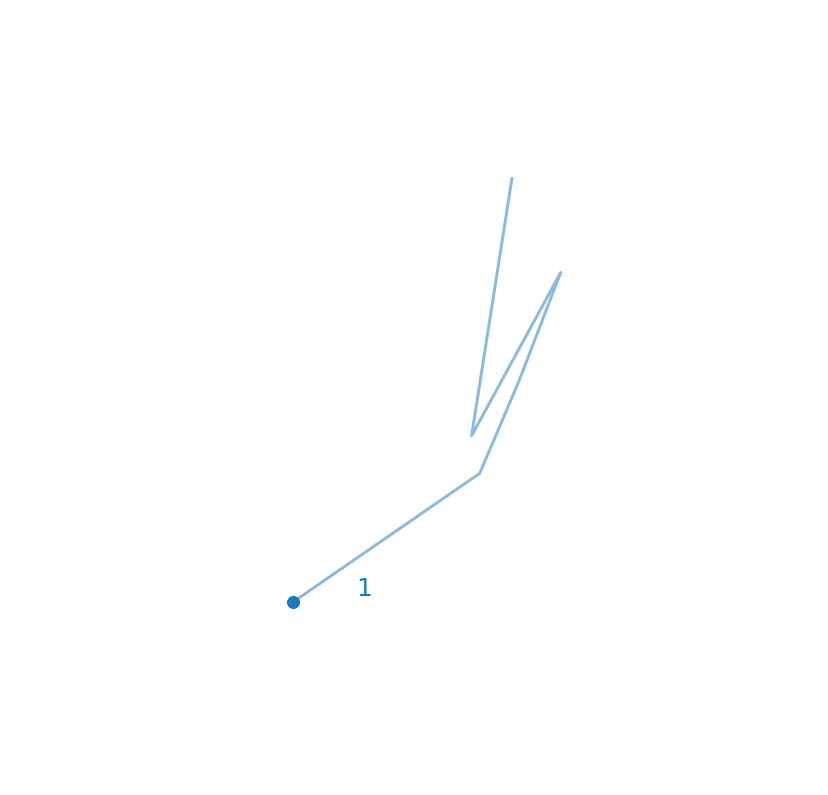

In [96]:
np_fig,fig_out, _ = transform_strokes_to_image(drawing_i, len_i, start_coor_i,
                                    mean_channel, std_channel, drawing_i.shape[0], log_dir, 'noutput_pruebas', square_figure=True, alpha=0.5, highlight_start=True)

In [38]:
np_fig.shape

(1100, 1100, 4)

In [39]:
%matplotlib inline

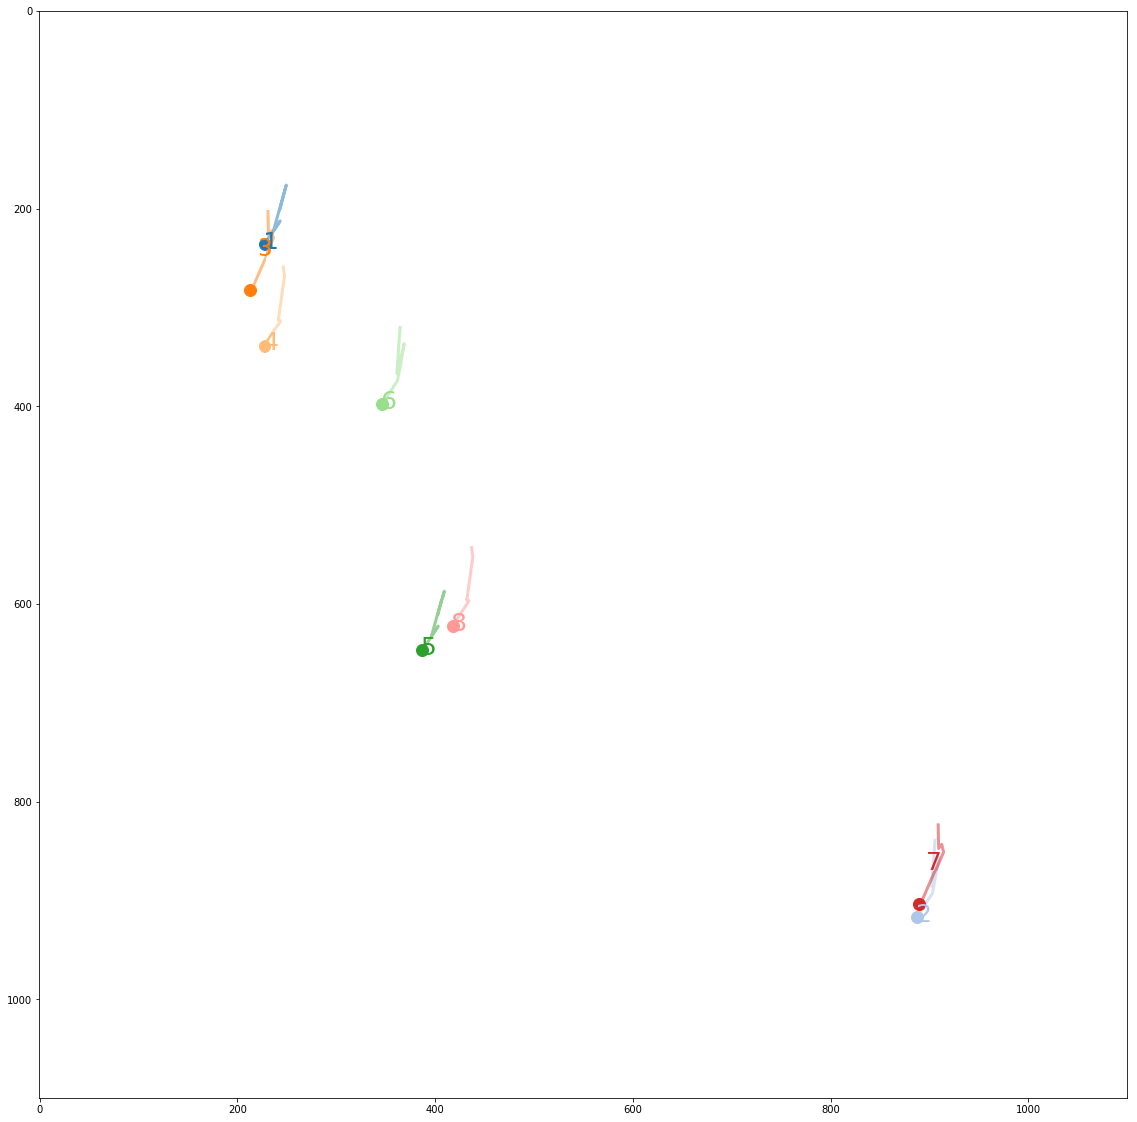

In [43]:
plt.figure(figsize = (20,20))
plt.imshow(np_fig,)

In [1]:
from data.loaders import *

In [2]:
from utils import * 

In [4]:
data_loader = get_batch_iterator("/data/ajimenez/cose/train")

In [5]:
for batch_input, batch_target in iter(data_loader):
    print(batch_input['seq_len'].shape)
    sys.exit(0)

torch.Size([1, 96])


NameError: name 'sys' is not defined

In [12]:
batch_input['encoder_inputs'][0][3]

tensor([[-0.3041, -0.2503,  0.0000],
        [-0.4012, -0.4150,  0.0000],
        [-0.4784, -0.5985,  0.0000],
        [-0.5537, -0.7905,  0.0000],
        [-0.6289, -0.9824,  0.0000],
        [-0.6912, -1.1436,  0.0000],
        [-0.7417, -1.2636,  0.0000],
        [-0.7781, -1.3270,  0.0000],
        [-0.8084, -1.3429,  0.0000],
        [-0.8336, -1.3170,  0.0000],
        [-0.8636, -1.2630,  0.0000],
        [-0.9032, -1.1738,  0.0000],
        [-0.9560, -1.0703,  0.0000],
        [-1.0152, -0.9718,  0.0000],
        [-1.0801, -0.8670,  0.0000],
        [-1.1302, -0.7882,  0.0000],
        [-1.1652, -0.7264,  0.0000],
        [-1.1786, -0.6887,  0.0000],
        [-1.1768, -0.6673,  0.0000],
        [-1.1597, -0.6535,  0.0000],
        [-1.1239, -0.6323,  0.0000],
        [-1.0716, -0.5946,  0.0000],
        [-1.0104, -0.5299,  0.0000],
        [-0.9465, -0.4376,  0.0000],
        [-0.8798, -0.3120,  0.0000],
        [-0.8301, -0.1725,  0.0000],
        [-0.7940, -0.0368,  0.0000],
 